##### SME0202 Métodos Numéricos em Equações Diferenciais Ordinárias
## Trabalho 2 - Problemas de Valor Inicial - Pêndulo Simples e Duplo
- Cody Stefano Barham Setti - 4856322
- Ian de Holanda Cavalcanti Bezerra - 13835412

#### Importanto Bibliotecas

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import ellipj, ellipk
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings('ignore')

#### Configurando Estilo dos Gráficos

In [18]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 12

### Tarefa 1 - Pêndulo Simples

#### Solução Analítica de Referência

Temos o seguinte PVI:
$$
\begin{cases}
    q^{\prime\prime}(t) + \sin(q(t)) = 0 \\
    q(0) = q_0 \\
    q^\prime(0) = 0
\end{cases}
$$
A solução analítica deste PVI é
$$
    q(t) = 2\arcsin\left\{\sin\left(\tfrac{q_0}{2}\right)\operatorname{sn}\left[K\left({\sin\left(\tfrac{q_0}{2}\right)}^2\right)-t;{\sin\left(\tfrac{q_0}{2}\right)}^2\right]\right\},
$$
onde $\operatorname{sn}(\cdot\,;\cdot)$ denota a função elíptica de Jacobi e $K(\cdot)$ a integral elíptica completa de primeira ordem.

In [19]:
def RefSolution(q_0, t):
    """
    Solução Analítica para o pêndulo simples usando funções elípticas

    Parâmetros:
    q_0: Amplitude inicial (rad - float)
      t: Array de tempo    (s - np.array)

    Retornos:
    q: Posição angular    (rad - float)
    p: Velocidade angular (rad/s - folat)
    """
    # Variáveis auxiliares
    k_0 = np.sin(q_0/2)

    # Integral elíptica completa de primeira ordem
    K = ellipk(k_0**2)

    # Funções elípticas de Jacobi: sn, cn, dn & ph
    sn, cn, _, _ = ellipj(K - t, k_0**2)

    # Posição angular
    q = 2 * np.arcsin(k_0 * sn)

    # Velocidade angular
    dq_dt = -2 * k_0 * cn

    return q, dq_dt

Se definirmos $p(t) \coloneqq q^\prime(t)$, então, podemos mudar de uma EDO de 2ª ordem para um sistema $2\times2$ de EDOs de primeira ordem, como descrito abaixo:
$$
\begin{cases}
    \begin{bmatrix}q(t) \\ p(t)\end{bmatrix}' = \begin{bmatrix}p(t) \\ \sin(q(t))\end{bmatrix} \\ \\
    \begin{bmatrix} q(0) \\ p(0)\end{bmatrix} = \begin{bmatrix}q_0 \\ 0\end{bmatrix}
\end{cases}
\qquad\text{ou, de forma mais enxuta,}\qquad
\begin{cases}
    \boldsymbol{q}'(t) = \boldsymbol{f}(\boldsymbol{q}(t)) \\
    \boldsymbol{q}(0) = \boldsymbol{\eta}
\end{cases}
$$
Note que este sistema é autônomo, isto é, $\boldsymbol{f}$ não depende diretamente de $t$.

In [20]:
def pendulum_system(y, t=0):
    """
    Representação do pêndulo simples como sistema de EDOs de 1ª ordem
    y = [p, q], onde q é a posição angular (rad) e p a velocidade angular (rad/s)
    (dtype[y] = lista contendo dois floats)
    """
    q, p = y
    dq_dt = p
    dp_dt = -np.sin(q)
    return np.array([dq_dt, dp_dt])

#### Tarefa 1.1 - Implementação dos Métodos de Euler, RK4 (Clássico) e Euler Implícito

Implementação do Método de Euler Explícito

In [21]:
def euler_explicit(f, y0, t_span, h):
    t = np.arange(t_span[0], t_span[1] + h, h)
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0

    for i in range(n-1):
        y[i+1][:] = y[i][:] + h * f(y[i][:])
    
    return t, y

Implementação do Método Runge-Kutta de 4ª Ordem Clássico

In [22]:
def rk4(f, y0, t_span, h):
    """Classical 4th order Runge-Kutta method"""
    t = np.arange(t_span[0], t_span[1] + h, h)
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    
    for i in range(n-1):
        k1 = f(y[i])
        k2 = f(y[i] + 0.5*h*k1)
        k3 = f(y[i] + 0.5*h*k2)
        k4 = f(y[i] + h*k3)
        y[i+1] = y[i] + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
    
    return t, y

Implementação do Método de Euler Implícito

In [23]:
def euler_implicit(f, y0, t_span, h, tol=1e-10, max_iter=50):
    """Implicit Euler method using Newton's method"""
    t = np.arange(t_span[0], t_span[1] + h, h)
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    
    for i in range(n-1):
        # Newton's method to solve: y_{n+1} = y_n + h*f(y_{n+1})
        y_guess = y[i] + h * f(y[i])  # Initial guess using explicit Euler
        
        for _ in range(max_iter):
            # For pendulum: f = [p, -sin(q)]
            q_guess, p_guess = y_guess
            
            # Residual: G(y) = y - y_n - h*f(y) = 0
            G = y_guess - y[i] - h * f(y_guess)
            
            # Jacobian of G: dG/dy = I - h*df/dy
            # For pendulum: df/dy = [[0, 1], [-cos(q), 0]]
            J = np.array([[1, -h],
                         [h*np.cos(q_guess), 1]])
            
            # Newton update
            delta = np.linalg.solve(J, -G)
            y_guess = y_guess + delta
            
            if np.linalg.norm(delta) < tol:
                break
        
        y[i+1] = y_guess
    
    return t, y

#### Tarefa 1.2 - Evolução Temporal do Pêndulo Simples Segundo os Métodos Numéricos Implementados

Condições iniciais elegidas para o PVI:

In [24]:
q0 = np.pi/4
p0 = 0
y0 = np.array([q0, p0])

Domínio temporal considerado:

In [25]:
t_span = [0, 20]

Discretização da evolução temporal elegida:

In [26]:
h = 0.01

Evoluções temporais do pêndulo simples fornecidas pelos *solvers* `euler_explicit`, `rk4` e `euler_implicit`:

In [27]:
t_euler,    y_euler    = euler_explicit(pendulum_system, y0, t_span, h)
t_rk4,      y_rk4      =            rk4(pendulum_system, y0, t_span, h)
t_implicit, y_implicit = euler_implicit(pendulum_system, y0, t_span, h)

# Resgatar solução de referência
q_ref, p_ref = RefSolution(q0, t_euler)

Gráficos fornecidos por cada *solver*

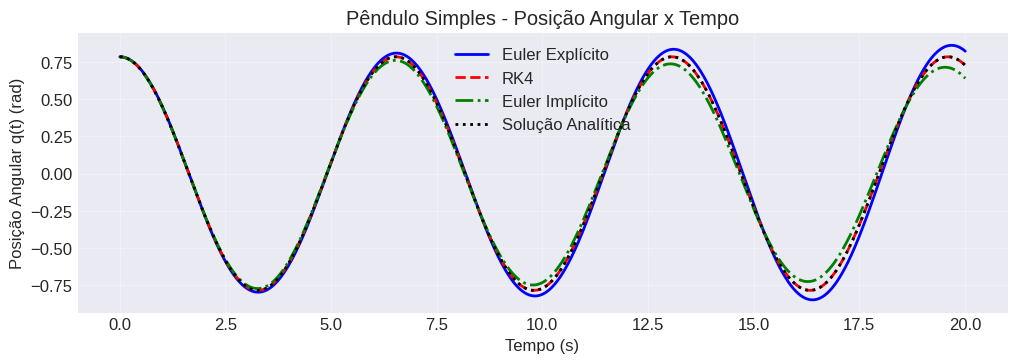

In [28]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(t_euler   , y_euler[:, 0]   , 'b-' , label='Euler Explícito'  , linewidth=2)
plt.plot(t_rk4     , y_rk4[:, 0]     , 'r--', label='RK4'              , linewidth=2)
plt.plot(t_implicit, y_implicit[:, 0], 'g-.', label='Euler Implícito'  , linewidth=2)
plt.plot(t_euler   , q_ref           , 'k:' , label='Solução Analítica', linewidth=2)
plt.xlabel('Tempo (s)')
plt.ylabel('Posição Angular q(t) (rad)')
plt.title('Pêndulo Simples - Posição Angular x Tempo')
plt.legend()
plt.grid(True, alpha=0.3)

Gráficos fornecidos por cada *solver* **em detalhe**

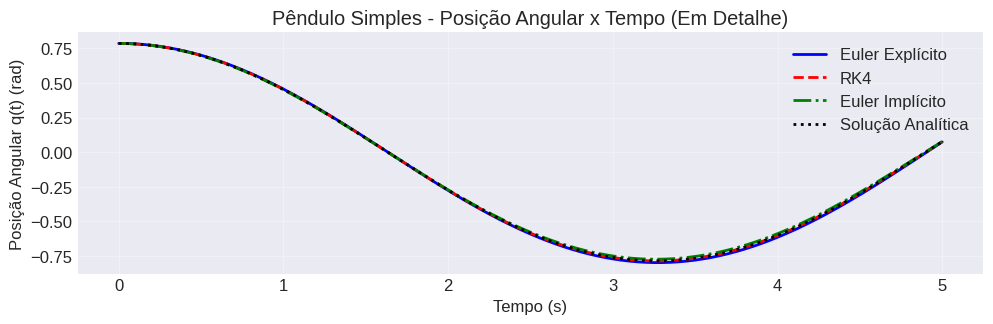

In [29]:
plt.subplot(2, 1, 2)
zoom_idx = t_euler <= 5
plt.plot(t_euler[zoom_idx]   , y_euler[zoom_idx, 0]   , 'b-' , label='Euler Explícito'  , linewidth=2)
plt.plot(t_rk4[zoom_idx]     , y_rk4[zoom_idx, 0]     , 'r--', label='RK4'              , linewidth=2)
plt.plot(t_implicit[zoom_idx], y_implicit[zoom_idx, 0], 'g-.', label='Euler Implícito'  , linewidth=2)
plt.plot(t_euler[zoom_idx]   , q_ref[zoom_idx]        , 'k:' , label='Solução Analítica', linewidth=2)
plt.xlabel('Tempo (s)')
plt.ylabel('Posição Angular q(t) (rad)')
plt.title('Pêndulo Simples - Posição Angular x Tempo (Em Detalhe)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Tarefa 1.3 - Análise de Ordem de Convergência dos Métodos Numéricos Implementados

In [30]:
def empirical_convergence_order(method):
    # Diferentes tamanhos de passo (de tempo)
    h_values = np.array([0.2, 0.1, 0.05, 0.025, 0.0125, 0.00625])

    # Tempo final observado é fixo, para uma comparação justa!
    T = 10.0
    
    # Inicialização de uma 'list' para armazenar o erro correspondente a cada tamanho de passo
    errors = []

    for h in h_values:
        # Aplicar método com tamanho de passo atual
        t_span = [0, T]
        t, y = method(pendulum_system, y0, t_span, h)

        # Resgatar solução de referência (nos mesmos pontos da solução aproximada)
        q_ref, p_ref = RefSolution(q0, t)

        # Erro dado pelo ponto de maior discrepância entre as soluções
        error_h = np.max(np.abs(y[:,0]) - q_ref)
        errors.append(error_h)

        # Calcular ordem de convergência
        rates = []
        for i in range(len(errors)-1):
            rate = np.log(errors[i]/errors[i+1]) / np.log(h_values[i]/h_values[i+1])
            rates.append(rate)
        
        return h_values, errors, rates

In [31]:
h_euler   , err_euler   , rates_euler    = empirical_convergence_order(euler_explicit)
h_rk4     , err_rk4     , rates_rk4      = empirical_convergence_order(rk4)
h_implicit, err_implicit, rates_implicit = empirical_convergence_order(euler_implicit)

ValueError: x and y must have same first dimension, but have shapes (6,) and (1,)

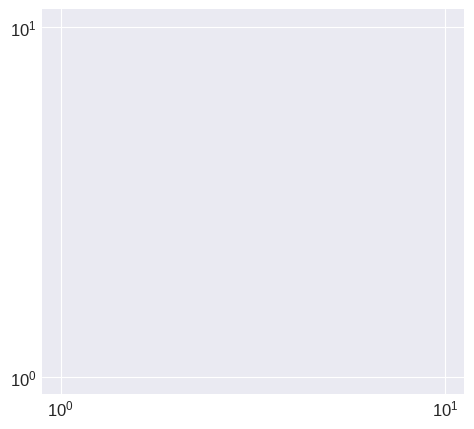

In [32]:
# Plot convergence
plt.figure(figsize=(12, 5))

# Error vs step size
plt.subplot(1, 2, 1)
plt.loglog(h_euler   , err_euler   , 'bo-', label='Euler Explícito', linewidth=2, markersize=8)
plt.loglog(h_rk4     , err_rk4     , 'rs-', label='RK4'            , linewidth=2, markersize=8)
plt.loglog(h_implicit, err_implicit, 'g^-', label='Euler Implícito', linewidth=2, markersize=8)

# Reference lines
plt.loglog(h_euler, h_euler   , 'k--', alpha=0.5, label='Primeira ordem')
plt.loglog(h_euler, h_euler**2, 'k-.', alpha=0.5, label='Segunda ordem')
plt.loglog(h_euler, h_euler**4, 'k:' , alpha=0.5, label='Quarta ordem')

plt.xlabel('Tamanho de Passo h')
plt.ylabel('Erro Máximo')
plt.title('Pêndulo Simples - Análise de Convergência')
plt.legend()
plt.grid(True, alpha=0.3)

# Convergence rates
plt.subplot(1, 2, 2)
plt.plot(h_euler[:-1]   , rates_euler   , 'bo-', label='Euler Explícito', linewidth=2, markersize=8)
plt.plot(h_rk4[:-1]     , rates_rk4     , 'rs-', label='RK4'            , linewidth=2, markersize=8)
plt.plot(h_implicit[:-1], rates_implicit, 'g^-', label='Euler Implícito', linewidth=2, markersize=8)
plt.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Ordem 1')
plt.axhline(y=2, color='k', linestyle='-.', alpha=0.5, label='Ordem 2')
plt.axhline(y=4, color='k', linestyle=':' , alpha=0.5, label='Ordem 4')
plt.xlabel('Tamanho de Passo h')
plt.ylabel('Taxa de Convergência')
plt.title('Ordem de Convergência Observada')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')

plt.tight_layout()
plt.show()

# Print convergence rates
print("Resultados da Análise de Convergência:")
print("="*50)
print(f"{'Método':<20} {'Ordem Média':<15} {'Ordem Esperaa':<15}")
print("-"*50)
print(f"{'Euler Explícito':<20} {np.mean(rates_euler):.2f} {1}")
print(f"{'RK4':<20} {np.mean(rates_rk4):.2f} {4}")
print(f"{'Euler Implícito':<20} {np.mean(rates_implicit):.2f} {1}")

#### Tarefa 1.4 - Diagramas de Fase

### Tarefa 2 - Pêndulo Duplo 